#Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#Análisis Exploratorio

In [3]:
#Leer el archivo
df = pd.read_csv("Social_Network_Ads.csv")

In [4]:
#Obtener dimensiones
df.shape

(400, 5)

In [34]:
#Muestra aleatoria
df.sample(10)

,User ID,Gender,Age,EstimatedSalary,Purchased
137,15687491,Male,30,107000,1
147,15749130,Female,41,30000,0
88,15768816,Male,26,81000,0
162,15599533,Female,37,33000,0
72,15595228,Female,20,23000,0
230,15794253,Female,35,147000,1
63,15583681,Male,32,120000,1
202,15735549,Female,39,134000,1
66,15679760,Male,24,19000,0
300,15736397,Female,58,38000,1


In [5]:
#Obtener los tipos de datos
df.dtypes

User ID             int64
Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [6]:
#Obtener la información general del DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [7]:
#Obtener información estadística de las variables cuantitativas
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [8]:
#Obtener información estadística de las variables cualitativas
df.describe(include = 'object')

,Gender
count,400
unique,2
top,Female
freq,204


#Pre-Procesamiento

##Datos Vacíos

In [9]:
#Obtener la cantidad de datos vacíos
df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [10]:
#Obtener la proporción/ratio de datos vacíos
ratio = ((df.isnull().sum() / len(df)) * 100)
print(ratio)

User ID            0.0
Gender             0.0
Age                0.0
EstimatedSalary    0.0
Purchased          0.0
dtype: float64


Como se puede ver, no hay datos vacíos por lo que no se les harán ningún tratamiento

#Prueba de normalidad
- Ho: la variable se aproxima a una distribución normal
- Ha: la variable no se aproxima a una distribución normal

- Si el pvalor =< 5% => Se rechaza la Ho, al 95% de confianza, las variable no se aproxima a una distribución normal
- Si el pvalor > 5% => No se rechaza la Ho, al 95% de confianza, las variable se aproxima a una distribución normal

In [11]:
#Obtener las variables numéricas
normalidad = df.select_dtypes(include = [np.float64, np.int64])

In [12]:
#Variables que siguen una distribución normal
for i in normalidad:
  stats, p_value = ss.shapiro(normalidad[i])
  
  if p_value <= 0.05:
    print("No Distribución normal:  ", i, " => ", p_value)

No Distribución normal:   User ID  =>  6.910501060275465e-10
No Distribución normal:   Age  =>  1.1638903743005358e-05
No Distribución normal:   EstimatedSalary  =>  5.734485331032602e-09
No Distribución normal:   Purchased  =>  3.6016551074618344e-29


In [13]:
#Variables que siguen una distribución normal
for i in normalidad:
  stats, p_value = ss.shapiro(normalidad[i])
  if p_value >= 0.05:
    print("Distribución normal: ", i, " => ", p_value)

Como se puede ver luego de realizar el análisis de shapiro, se puede concluir que las variables User ID, Age, EstimatedSalary y Purchased no siguen una función normal porque su pvalue es menor a 5%. Estas son todas las variables numéricas y la variable Gender es categórica (se transformará más adelante).

#Correlación de Datos
- Si las variables se aproximan a una distribución normal => Pearson
- Si las variables no se aproximan a una distribución normal => Spearman

##Mapa de correlación (Heatmap)

In [14]:
corre = df.copy()

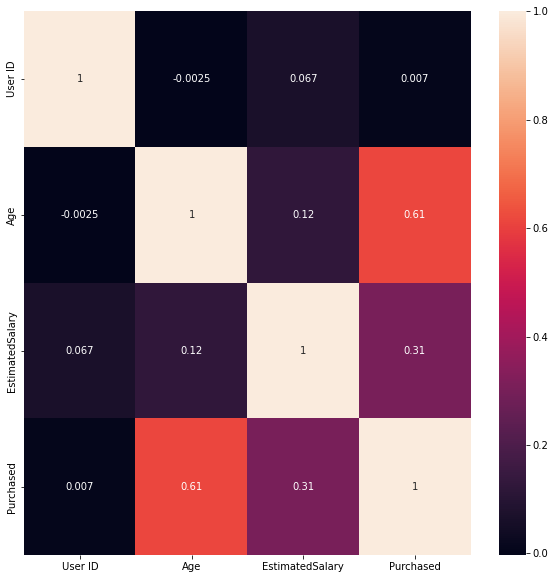

In [15]:
#Se realiza un heatmap para ver la correlación de las variables
plt.figure(figsize = (10,10))
sns.heatmap(corre.corr(method = 'spearman'), annot = True)
plt.show()

En base al mapa de calor, se puede concluir que casi todas las variables no tienen correlación entre ellas. Sin embargo, las variables que parecen tener una ligera correlación son Age con Purchased. 

Aún no se puede concluir ya que este es un método subjetivo para ver la correlación, se corroborará con la prueba de correlación.

##Prueba de correlación
- Pvalue < 5% => no existe correlación entre las variables
- Pvalue >= 5% => existe correlación entre las variables

In [16]:
#Prueba de Spearman
ss.spearmanr(df['Age'], df['Purchased'])

SpearmanrResult(correlation=0.6123232966381384, pvalue=1.5900034008998687e-42)

Luego de realizar la prueba de correlación, se puede concluir que las variables de Age y Purchased no están correlacionadas ya que su pvalue es menor al 5%

#Prueba de Chi-Cuadrado:
- Si pvalor < 5% => existe dependencia entre las variables
- Si pvalor >= 5% => no existe dependencia entre las variables

**IMPORTANTE:** La variable objetivo/Target/Dependiente es 'Purchased'. Esta es la variable que se desea predecir.

In [17]:
chi = df.select_dtypes(include = [np.float64, np.int64])
chi.drop(['Purchased'], axis=1, inplace=True)

for x in chi:
  variables = pd.crosstab(df[x], df['Purchased'])
  c, pvalue, dof, expected = chi2_contingency(variables)

  #Mostrar las variables que tienen una dependencia con la variable objetivo
  if pvalue <= 0.05:
    print("Variable: ", x, " => ", pvalue)

Variable:  Age  =>  2.0150569055145017e-23
Variable:  EstimatedSalary  =>  3.0871176800643303e-07


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Luego de realizar la prueba de Chi, se puede concluir que las variables que tienen una dependencia con 'Purchased' son Age y EstimatedSalary. Esto se puede concluir ya que su pvalue es menor o igual a 5%

#Gráfico de violín

Se realizarán los gráficos de violín con las variables de EstimatedSalary, Age y Gender. Estas serán comparadas con Purchased para ver cómo varían entre sí

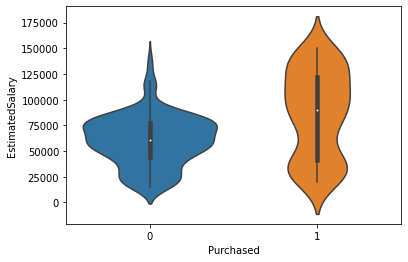

In [18]:
#Gráfico de EstimatedSalary vs Purchased
sns.violinplot(x = 'Purchased', y = 'EstimatedSalary', data = df)
plt.show()

**Conclusiones:**
- Se puede concluir que las personas que sí compraron tienen un salario de 100000 para arriba (un salario alto)
- Las personas que no compraron son personas que no tienen un salario muy alto 75000 a menos (salario bajo), son muy pocas las que tienen un salario alto que no compraron

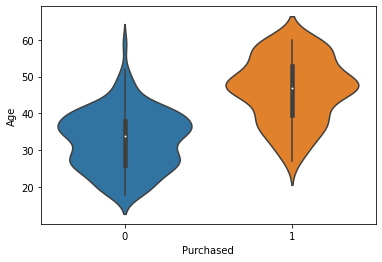

In [19]:
#Gráfico de Age vs Purchased
sns.violinplot(x = 'Purchased', y = 'Age', data = df)
plt.show()

**Conclusiones:**
- Se puede concluir que las personas que sí compraron tienen una edad mayor, de 40 para arriba en su gran mayoría
- Las personas que no compraron son personas que son más jóvenes, la gran mayoría está en el rango de 10-40 años.

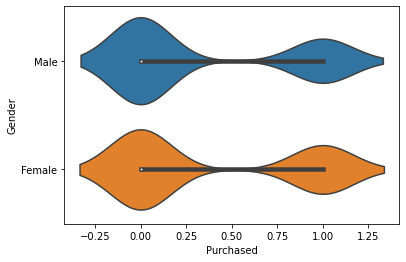

In [20]:
#Gráfico de Gender vs Purchased
sns.violinplot(x = 'Purchased', y = 'Gender', data=df)
plt.show()

Gender     Female  Male
Purchased              
0             127   130
1              77    66


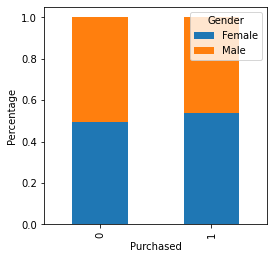

In [21]:
print(pd.crosstab(df["Purchased"],df["Gender"]))
Gender = pd.crosstab(df["Purchased"],df["Gender"])
Gender.div(Gender.sum(1).astype(float),axis=0).plot(kind="bar",stacked=True,figsize=(4,4))
plt.xlabel("Purchased")
plt.ylabel("Percentage")
plt.show()

**Conclusiones:**
- En base al gráfico del violín, no se puede concluir que la compra se vea afectada por el género ya que casi no hay variación.

- Para comprobar que no afecta la compra, se hizo un gráfico de columnas para verificar si la compra era afectada por el género o no. Se eligió este gráfico ya que éste sirve para variables cualitativas y poder tener un mejor análisis. En base a este gráfico, se pudo corroborar que la compra no se ve afectada por el género.

#Modelos

In [26]:
modelos = df.copy()

In [35]:
#Seleccionar datos para el modelo
X = modelos.iloc[:,[2,3]].values
y = modelos['Purchased']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

##Naive Bayes

In [37]:
X_train = X_train
X_test = X_test

In [38]:
#Entrenar el modelo
classifier = GaussianNB().fit(X_train, y_train)

In [39]:
#Comprobar las predicciones
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[56  2]
 [ 4 18]]
Normalized confusion matrix
[[0.96551724 0.03448276]
 [0.18181818 0.81818182]]


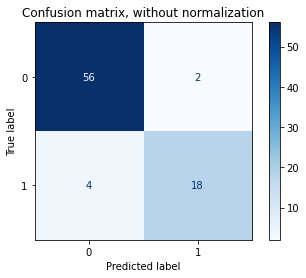

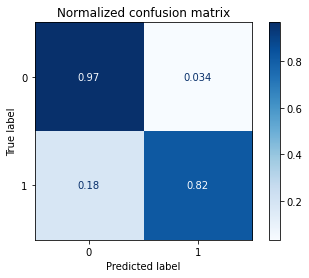

In [40]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [41]:
#Obtener la probabilidad de las predicciones
y_pred_prob = classifier.predict_proba(X_test)

In [42]:
#Obtener los falsos positivos, verdaderos positivos, etc
false_positive_rate1, true_positive_rate1, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [43]:
#Calcular curva ROC
roc_aucBayes = auc(false_positive_rate1, true_positive_rate1)
roc_aucBayes

0.9843260188087775

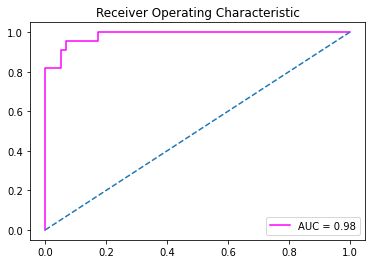

In [60]:
#Mostrar gráfico de curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1,true_positive_rate1, color='magenta',label = 'AUC = %0.2f' % roc_aucBayes)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

##KNN

In [82]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [89]:
#Tuning
k_range = range(1, 20)
k_scores = []

In [90]:
#Calcular el score para cada uno
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

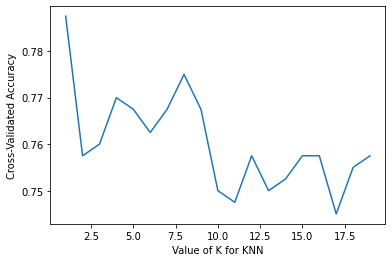

In [91]:
#Mostrar los valores de K del 1 al 20
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [92]:
#Obtener el mejor K
maxi = max(k_scores)
pos = k_scores.index(max(k_scores)) + 1
print("El mejor K es: ", maxi, "y se encuentra en la posición: ", pos)

El mejor K es:  0.7875 y se encuentra en la posición:  1


Se obtuvo que el K (número de vecinos) más óptimo en el tunning es de 1

In [93]:
#Entrenar el modelo con los mejores atributos
classifier = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [94]:
#Obtener las predicciones
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[55  3]
 [ 3 19]]
Normalized confusion matrix
[[0.94827586 0.05172414]
 [0.13636364 0.86363636]]


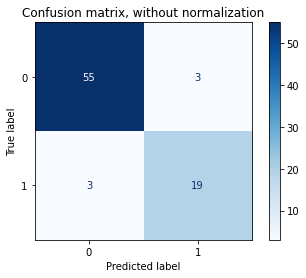

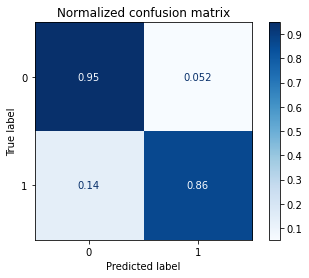

In [96]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [97]:
#Probabilidad de las predicciones:
y_pred_prob = classifier.predict_proba(X_test)

In [98]:
#Verdaderos positivos, falsos positivos
false_positive_rate2, true_positive_rate2, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [99]:
#Obtener curva ROC
roc_aucKNN = auc(false_positive_rate2, true_positive_rate2)
roc_aucKNN

0.9059561128526646

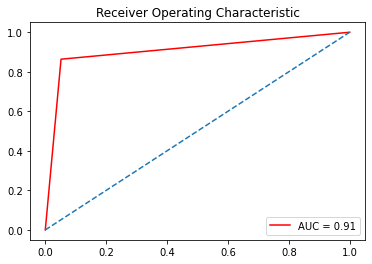

In [100]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate2,true_positive_rate2, color='red',label = 'AUC = %0.2f' % roc_aucKNN)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

##Árbol de decisión

In [71]:
#Tuning: se realiza para obtener los mejores parámetros (mejor combinación) de árbol de decisión
param_grid = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [72]:
#Buscar los mejores parámetros
grid = GridSearchCV(tree.DecisionTreeClassifier(),param_grid,refit=True,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=10; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=10; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=10; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=10; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=10; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_samples_leaf=20; total time=   0.0s
[CV] END ...criterion=gini, max_depth=2, min_sa

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             verbose=2)

In [73]:
#Mostrar los mejores parámetros
print(grid.best_estimator_)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)


In [74]:
#Entrenar el árbol de decisión con los mejores parámetros
classifier = tree.DecisionTreeClassifier(max_depth=2, min_samples_leaf=5).fit(X_train, y_train)

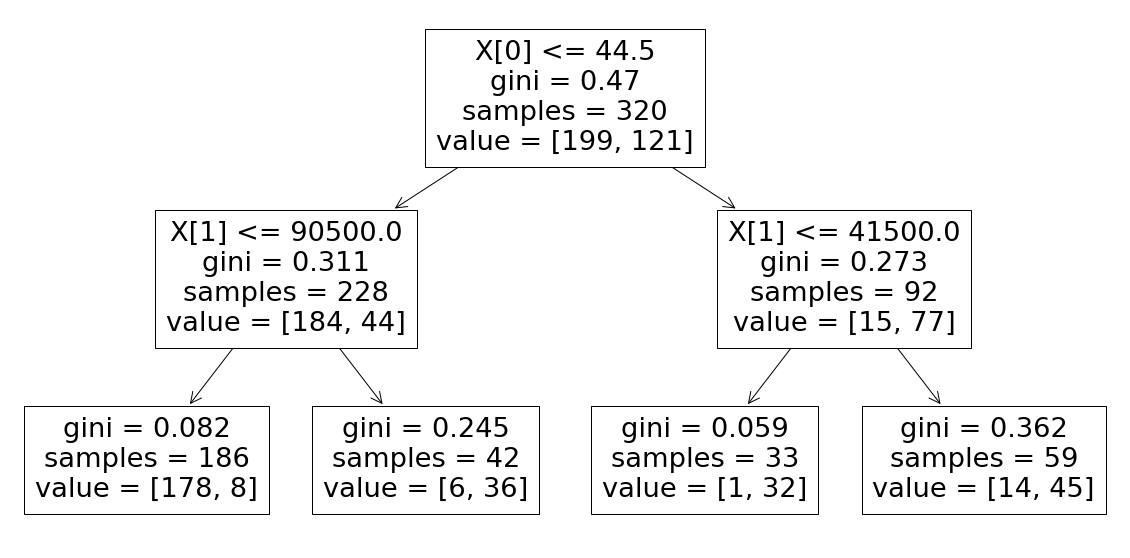

In [75]:
#Mostrar árbol de decisión
plt.figure(figsize = (20,10))
tree.plot_tree(classifier)
plt.show()

In [76]:
#Verificar lo predecido
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[55  3]
 [ 1 21]]
Normalized confusion matrix
[[0.94827586 0.05172414]
 [0.04545455 0.95454545]]


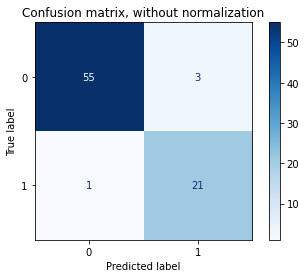

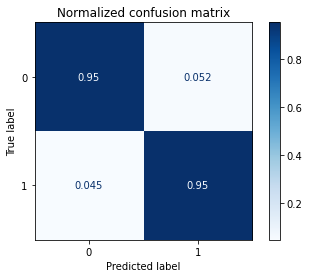

In [77]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [78]:
#Obtener la probabilidad de lo predecido
y_pred_prob = classifier.predict_proba(X_test)

In [79]:
#Verdaderos positivos, falsos positivos
false_positive_rate3, true_positive_rate3, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [80]:
#Obtener curva ROC
roc_aucTree = auc(false_positive_rate3, true_positive_rate3)
roc_aucTree

0.9494514106583072

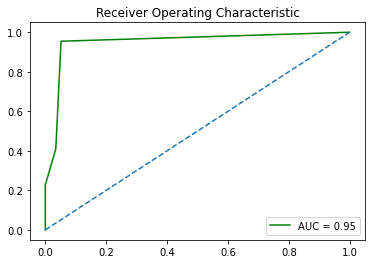

In [81]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate3,true_positive_rate3, color='green',label = 'AUC = %0.2f' % roc_aucTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

##Redes neuronales

In [61]:
#Tuning: se realiza para obtener los mejores parámetros para realizar el modelo
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [62]:
#Se busca el mejor modelo
grid = GridSearchCV(MLPClassifier(max_iter=500),param_grid,refit=True,verbose=2,cv=5)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam; total time=   0.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam; total time=   0.0s
[CV] END activation=tanh, alpha=0.0001, 

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=500),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=2)

In [63]:
#Mostrar mejores parámetros
print(grid.best_estimator_)

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=500,
              solver='sgd')


In [64]:
#Construir red neuronal con los mejores parámetros
classifier = MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(10, 30, 10), learning_rate='adaptive', solver = 'sgd', max_iter=500).fit(X_train, y_train)

In [65]:
#Predicciones
y_pred = classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[58  0]
 [22  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


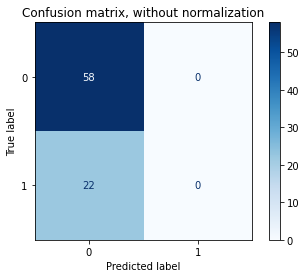

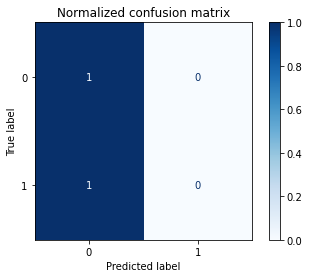

In [66]:
#Matriz de confusión
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 #display_labels=y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [67]:
#Probabilidades de las predicciones
y_pred_prob = classifier.predict_proba(X_test)

In [68]:
#Falsos positivos, verdaderos positivos
false_positive_rate4, true_positive_rate4, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [69]:
#Curva ROC
roc_aucRedes = auc(false_positive_rate4, true_positive_rate4)
roc_aucRedes

0.5

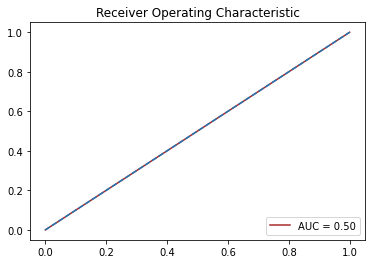

In [70]:
#Mostrar curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate4,true_positive_rate4, color='brown',label = 'AUC = %0.2f' % roc_aucRedes)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

#Comparaciones de modelos

##Comparar curva ROC

- Bayes = 0.98
- KNN = 0.91
- árbol de decisión = 0.95
- Redes neuronales = 0.5

**Conclusiones:**
- En base a la curva ROC, se puede concluir que el mejor modelo es el de naive bayes con una ROC de 0.98. 

- En base a la curva ROC se puede concluir que las redes neuronales son el peor modelo ya que su AUC es de 0.5, dándole la misma exactitud que un modelo aleatorio. Además, su ROC es el más bajo de todos haciéndolo el peor modelo.

- En el indicador de la curva ROC, mientras más cerca a 1 sea el valor, más adecuado será y mientras más lejos el modelo será menos adecuado.

##Comparar Matriz de confusión

Comparando la sensibilidad de cada modelo:
- Bayes = 0.82
- KNN = 0.86
- Decision Tree = 0.95
- Redes Neuronales = 0

En base a la sensibilidad, el Decision Tree es el que acertó más verdaderos positivos con un 95% y las redes neuronales es el peor con un 0%

##Mostrar todas las curvas

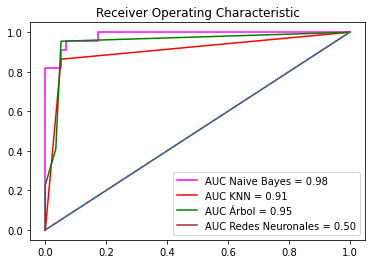

In [101]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1,true_positive_rate1, color='magenta',label = 'AUC Naive Bayes = %0.2f' % roc_aucBayes)
plt.plot(false_positive_rate2,true_positive_rate2, color='red',label = 'AUC KNN = %0.2f' % roc_aucKNN)
plt.plot(false_positive_rate3,true_positive_rate3, color='green',label = 'AUC Árbol = %0.2f' % roc_aucTree)
plt.plot(false_positive_rate4,true_positive_rate4, color='brown',label = 'AUC Redes Neuronales = %0.2f' % roc_aucRedes)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.show()

##Conclusión
Se puede concluir que el modelo de Decision Tree es el mejor modelo ya que su curva ROC es de 0.95 y su sensibilidad también es bastante alta (0.95), convirtiéndolo en el mejor modelo para realizar las predicciones.